In [23]:
import slim_conservation_scoring.seqtools.general_utils as tools
import pandas as pd
import numpy as np
import slim_conservation_scoring.pipeline.group_conservation_objects as group_tools
import pairk
from pathlib import Path
from Bio import AlignIO, Seq, SeqIO, Align
import seaborn as sns
from sklearn import metrics
from slim_conservation_scoring.seqtools import pssms
import logomaker as lm
from ast import literal_eval
import slim_conservation_scoring.conservation_scores.tools.pairwise_tools as pairwise_tools
import slim_conservation_scoring.conservation_scores.tools.score_plots as score_plots
import slim_conservation_scoring.conservation_scores.tools.basic_plotting as basic_plots
from dataclasses import dataclass

import matplotlib.pyplot as plt
plt.style.use('custom_standard')
import seaborn as sns

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
tablefile = "../../benchmark/benchmark_v4/p3_conservation/benchmark_table_ANNOTATED.csv"
df = pd.read_csv(tablefile)

In [17]:
def convert_jsonfile_to_relative(json_file):
    return json_file.replace("/home/jch/Documents/08-benchmark/", "../../")

In [25]:
from attrs import asdict, define, field, validators


@define
class PairwiseScoreResults:
    flanked_hit: str
    flanked_hit_start_position_in_idr: int
    original_hit_st_in_flanked_hit: int
    original_hit_end_in_flanked_hit: int
    function_name: str
    function_params: dict
    lflank: int
    rflank: int
    kmer_aln_file: str | Path
    flanked_hit_sequence: str
    flanked_hit_scores: list
    flanked_hit_z_scores: list
    hit_sequence: str
    hit_scores: list
    hit_z_scores: list
    pairk_conservation_params: dict
    bg_std: float

    def __attrs_post_init__(self):
        self.kmer_aln_file = convert_jsonfile_to_relative(self.kmer_aln_file)


@dataclass
class AlnScoreResults:
    file: str
    function_name: str
    function_params: dict
    hit_scores: list
    hit_z_scores: list


def slice_aln_scores(lvlo: group_tools.LevelAlnScore, aln_start, aln_end):
    hit_slice = slice(aln_start, aln_end + 1)
    hit_scores = lvlo.scores[hit_slice]
    hit_z_scores = lvlo.z_scores[hit_slice]
    hit_aln_seq = lvlo.query_aln_sequence[hit_slice]
    return hit_scores, hit_z_scores, hit_aln_seq


def json2logoplot_alnscore(
    jsonfile, score_key, with_gaps=False, axes=None, level="Vertebrata", flank=5
):
    og = group_tools.ConserGene(
        jsonfile, filepath_converter=convert_jsonfile_to_relative
    )
    lvlo = og.get_aln_score_obj(
        level, score_key, filepath_converter=convert_jsonfile_to_relative
    )
    # aln = jch_alignment.jch_alignment(lvlo.aln, og.query_gene_id)
    flst, flend, flhit = tools.pad_hit(
        og.query_idr_sequence,
        og.hit_st_in_idr,
        og.hit_end_in_idr,
        l_flank=flank,
        r_flank=flank,
    )
    query_idr, index = tools.reindex_alignment_str(
        lvlo.query_aln_sequence[lvlo.idr_aln_start : lvlo.idr_aln_end + 1]
    )
    flstaln, flendaln = index[flst], index[flend]
    flanked_hit_scores, flanked_hit_z_scores, flhit_aln_seq = slice_aln_scores(
        lvlo, flstaln + lvlo.idr_aln_start, flendaln + lvlo.idr_aln_start
    )
    idr_aln = lvlo.aln[:, lvlo.idr_aln_start : lvlo.idr_aln_end + 1]
    flhit_aln = idr_aln[:, flstaln : flendaln + 1]

    if not with_gaps:
        seqlist, query_slice, nongapinds = score_plots.strip_gaps_from_slice(
            flhit_aln, flhit_aln_seq
        )
        score_list = list(np.array(flanked_hit_z_scores)[nongapinds])
    else:
        seqlist = [str(i.seq) for i in list(flhit_aln)]
        query_slice = flhit_aln_seq
        score_list = flanked_hit_z_scores
    if axes is None:
        fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 4))
    basic_plots.plot_score_bar_plot(
        ax=axes[0],
        score_list=score_list,
        query_seq=query_slice,
    )
    basic_plots.plot_logo(
        ax=axes[1],
        str_list=seqlist,
        tick_label_str=query_slice,
    )
    counts = pssms.alignment_2_counts(seqlist, show_plot=False, heatmap=False)
    return counts


def json2logoplot(
    jsonfile, score_key, rbm: bool = False, axes=None, level="Vertebrata"
):
    og = group_tools.ConserGene(
        jsonfile, filepath_converter=convert_jsonfile_to_relative
    )
    lvlo = og.get_level_obj(level, filepath_converter=convert_jsonfile_to_relative)
    result = PairwiseScoreResults(**lvlo.conservation_scores[score_key])
    mat_res = pairk.PairkAln.from_file(result.kmer_aln_file)
    subseqdf = mat_res.orthokmer_matrix.copy()
    seqlist = subseqdf.loc[result.flanked_hit_start_position_in_idr].to_list()
    if axes is None:
        fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 4))
    basic_plots.plot_score_bar_plot(
        ax=axes[0],
        score_list=result.flanked_hit_z_scores,
        query_seq=result.flanked_hit_sequence,
    )
    basic_plots.plot_logo(
        ax=axes[1], str_list=seqlist, tick_label_str=result.flanked_hit_sequence
    )
    counts = pssms.alignment_2_counts(seqlist, show_plot=False, heatmap=False)
    return counts, result

In [14]:
temp['json_file'].values[0]

'/home/jch/Documents/08-benchmark/benchmark/benchmark_v4/p3_conservation/conservation_analysis/2333-9606_0_00294e/2333-9606_0_00294e.json'

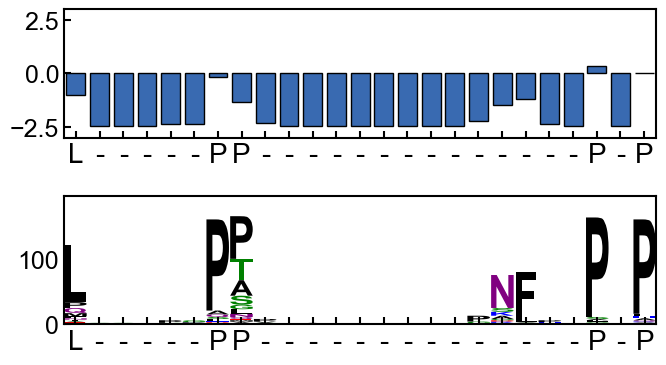

In [18]:
start=553
# end=557
gene_id='9606_0:00294e'
temp=df[(df['gene_id']==gene_id) & (df['hit start position']==start)].copy()
fig, axes = plt.subplots(nrows=2, figsize=(7, 4))
_ = json2logoplot_alnscore(temp['json_file'].values[0], 'aln_property_entropy', axes=axes, level='Vertebrata', with_gaps=True, flank=0)
axes[0].set_ylim([-3, 3])
for ax in axes:
    ax.tick_params(axis="x", which="major", labelsize=20)
plt.tight_layout()
plt.savefig('logo-RIAM-MSA_with_gaps.png', bbox_inches='tight', dpi=300)

In [26]:
def plots_from_df(df, level):
    for i, row in df.iterrows():
        jsonfile = row['json_file']
        fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(13, 4))
        _=json2logoplot_alnscore(jsonfile, 'aln_property_entropy', axes=ax[:,0], level=level, with_gaps=False, flank=0)
        _=json2logoplot(jsonfile, 'pairk_aln_lf0_rf0_edssmat50', rbm=False, axes=ax[:,1], level=level)
        _=json2logoplot(jsonfile, 'pairk_aln_embedding_lf0_rf0', rbm=False, axes=ax[:,2], level=level)
        for axi in ax[0,:]:
            axi.set_ylim([-3, 3])
        plt.tight_layout()
    return fig, ax

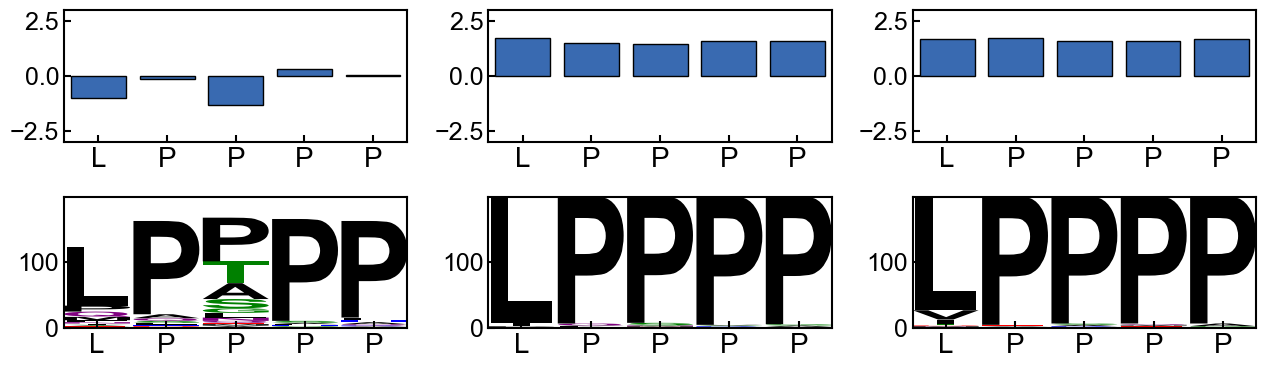

In [27]:
fig, axes = plots_from_df(temp, 'Vertebrata')
for ax in axes.flatten():
    ax.tick_params(axis="x", which="major", labelsize=20)
plt.savefig('logo-RIAM-MSA_pairk_pairkembedding.png', bbox_inches='tight', dpi=300)